In [ ]:
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from tqdm import tqdm
import argparse

class AdmissionsDataset(Dataset):
    """Dataset class for loading and accessing admissions data."""
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)


class MLP(nn.Module):
    """Multi-layer perceptron model for classifying admissions data."""
    def __init__(self, input_dim=14, hidden_dim=64, output_dim=4):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.activation(self.lin1(x))
        x = self.activation(self.lin2(x))
        x = self.lin3(x)
        return x
    
    def save_representations(self, x):
        """Save intermediate representations for analysis."""
        np.save('data/original_rep.npy', x.detach().numpy())
        x = self.activation(self.lin1(x))
        np.save('data/layer1_rep.npy', x.detach().numpy())
        x = self.activation(self.lin2(x))
        np.save('data/layer2_rep.npy', x.detach().numpy())


class AdmissionsClassifier:
	"""Class for handling data loading, preprocessing, training, and testing the MLP model."""
	def __init__(self, args):
		self.batch_size = args.batch_size
		self.train_epoch = args.train_epoch
		self.lr = args.lr
		self.verbose = args.verbose
		self.data_path = args.data_path
		self.model = MLP()
	
	def load_data(self):
		"""Load and preprocess the data from the CSV file."""
		def to_float(input):
			return float(input) if input else -1

		def format_row(row):
			features = [to_float(row[col]) for col in 
						['satv_use', 'satm_use', 'satcomp_use', 'act_eng', 
						 'act_math', 'act_read', 'act_sci', 'act_comp', 
						 'nc1', 'nc2', 'nc3', 'ncav', 'hs_gpa', 'college_gpa']]
			# labels: [Admit, Denied, Waitlisted, Others]
			label = [0, 0, 0, 0]
			if row['vt_adm_dec'] == 'admitted':
				label[0] = 1
			elif row['vt_adm_dec'] == 'rejected':
				label[1] = 1
			elif row['vt_adm_dec'] == 'waitlisted':
				label[2] = 1
			else:
				label[3] = 1
			return features, label

		with open(self.data_path, 'r', newline='', encoding='utf-8') as file:
			reader = csv.DictReader(file)
			data, labels = zip(*[format_row(row) for row in reader])

		data = np.array(data)
		data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0) + 1e-6)
		labels = np.array(labels)
		
		train_size = int(len(data) * 0.8)
		indices = list(range(len(data)))
		random.shuffle(indices)
		
		train_indices = indices[:train_size]
		test_indices = indices[train_size:]
		
		train_data = data[train_indices]
		test_data = data[test_indices]
		train_labels = labels[train_indices]
		test_labels = labels[test_indices]

		self.train_loader = DataLoader(AdmissionsDataset(train_data, train_labels), batch_size=self.batch_size, shuffle=True)
		self.test_loader = DataLoader(AdmissionsDataset(test_data, test_labels), batch_size=self.batch_size, shuffle=False)
	
	def train(self):
		"""Train the model on the training dataset."""
		optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
		criterion = nn.CrossEntropyLoss()
		
		for epoch in tqdm(range(self.train_epoch)):
			for batch_idx, (data, labels) in enumerate(self.train_loader):
				data = data.float()
				labels = labels.float()
				
				optimizer.zero_grad()
				predictions = self.model(data)
				loss = criterion(predictions, labels)
				loss.backward()
				optimizer.step()
				
				if batch_idx % self.verbose == 0:
					print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")
			print(f"Epoch {epoch}, Test Accuracy: {self.test_accuracy()}")
	
	def test_accuracy(self):
		"""Compute accuracy on the test dataset."""
		correct = 0
		total = 0
		with torch.no_grad():
			for data, labels in self.test_loader:
				data = data.float()
				predictions = self.model(data)
				predicted_labels = torch.argmax(predictions, dim=1)
				actual_labels = torch.argmax(labels, dim=1)
				correct += (predicted_labels == actual_labels).sum().item()
				total += labels.size(0)
		return correct / total
	
	def save_representations(self):
		"""Save representations from various model layers."""
		sample_data, _ = next(iter(self.train_loader))
		self.model.save_representations(sample_data.float())

# Parsing arguments
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', 
                    type=int, 
                    default=300, 
                    help='the number of data samples processed together in one forward and backward pass')
parser.add_argument('--train_epoch', type=int, default=5)
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate hyperameter')
parser.add_argument('--verbose', type=int, default=10)
parser.add_argument('--data_path', type=str, default='data.csv')
args = parser.parse_args(args=['--data_path', 'data/ext_dataset1.csv'])

model = AdmissionsClassifier(args)
model.load_data()
model.train()
		

### filter data based on admission result from layers and labels npy representations

In [51]:
import numpy as np

def remove_admres_rows(data_path, label_path, output_data_path, output_label_path, remove_label_indices):
    """
    Remove rows where the admission result labels match a given list of indices.

    Args:
        data_path (str): Path to the feature data (.npy file).
        label_path (str): Path to the label data (.npy file, one-hot encoded).
        output_data_path (str): Output path for filtered features.
        output_label_path (str): Output path for filtered labels.
        remove_label_indices (list): List of label indices to remove.
    """
    # Load data and labels
    data = np.load(data_path)
    labels_one_hot = np.load(label_path)

    # Convert one-hot labels to integer labels
    labels = np.argmax(labels_one_hot, axis=1)

    # Create a mask for rows to KEEP (exclude specified label indices)
    keep_indices = ~np.isin(labels, remove_label_indices)

    # Filter data and labels
    filtered_data = data[keep_indices]
    filtered_labels_one_hot = labels_one_hot[keep_indices]

    print(f"Removed {len(data) - len(filtered_data)} rows with labels in {remove_label_indices}.")

    # Save the filtered data and labels
    np.save(output_data_path, filtered_data)
    np.save(output_label_path, filtered_labels_one_hot)

label_admres_path = 'data/original/label_admres.npy'
output_label_admres_path = 'data/original/filtered_label_admres.npy'

# Remove rows with admission result "withdrawn/others" (index 3)
remove_admres_rows(
    'data/original/layer1_rep.npy', 
    label_admres_path, 
    'data/original/filtered_layer1_rep.npy', 
    output_label_admres_path, 
    [3]
)

remove_admres_rows(
    'data/original/layer2_rep.npy', 
    label_admres_path, 
    'data/original/filtered_layer2_rep.npy', 
    output_label_admres_path, 
    [3]
)

# Remove rows with admission result, leave only admitted
remove_admres_rows(
    'data/original/layer1_rep.npy', 
	'data/original/label_college.npy',
    'data/original/filtered_layer1_rep_admitted.npy', 
	'data/original/filtered_label_college_admitted.npy',
    [1, 2, 3]
)

remove_admres_rows(
    'data/original/layer2_rep.npy', 
	'data/original/label_college.npy',
    'data/original/filtered_layer2_rep_admitted.npy', 
	'data/original/filtered_label_college_admitted.npy',
    [1, 2, 3]
)


Removed 2083 rows with labels in [3].
Removed 2083 rows with labels in [3].
Removed 15131 rows with labels in [1, 2, 3].
Removed 15131 rows with labels in [1, 2, 3].


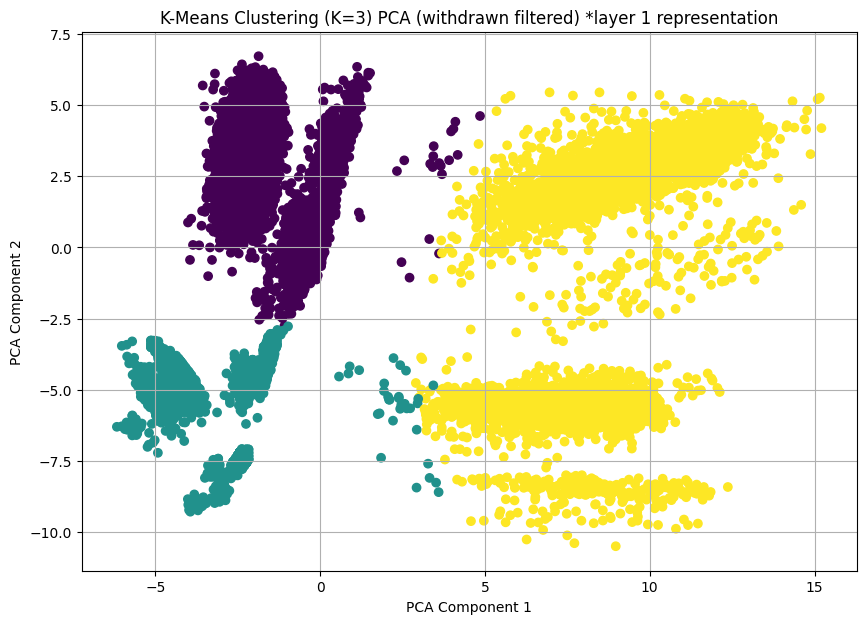

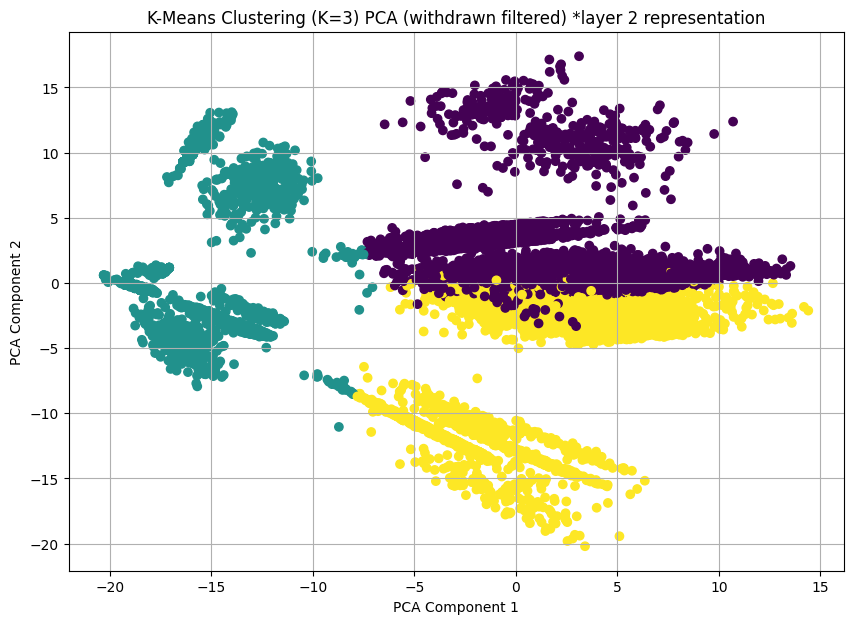

In [53]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def kmeans_pca(npy_file_path='data/original_rep.npy', n_clusters=3, title=''):
	scaler = StandardScaler()
	layer1_rep = np.load(npy_file_path)
	data_standardized = scaler.fit_transform(layer1_rep)

	kmeans = KMeans(n_clusters=n_clusters, random_state=42)
	kmeans.fit(data_standardized)
	labels = kmeans.labels_

	pca = PCA(n_components=2)
	reduced_data = pca.fit_transform(data_standardized)

	plt.figure(figsize=(10, 7))
	plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)

	plt.title("K-Means Clustering (K={}) PCA (withdrawn filtered) {}".format(n_clusters, '*' + title))
	plt.xlabel("PCA Component 1")
	plt.ylabel("PCA Component 2")
	plt.grid(True)
	plt.show()

kmeans_pca('data/original/filtered_layer1_rep.npy', 3, 'layer 1 representation')
kmeans_pca('data/original/filtered_layer2_rep.npy', 3, 'layer 2 representation')



PCA reveals the presece of clusters within the original dataset based on all columns suggesting that the data exhibits inherent groupings. This allows us to proceed with a more detailed analysis using specific clustering metrics to understand patterns.

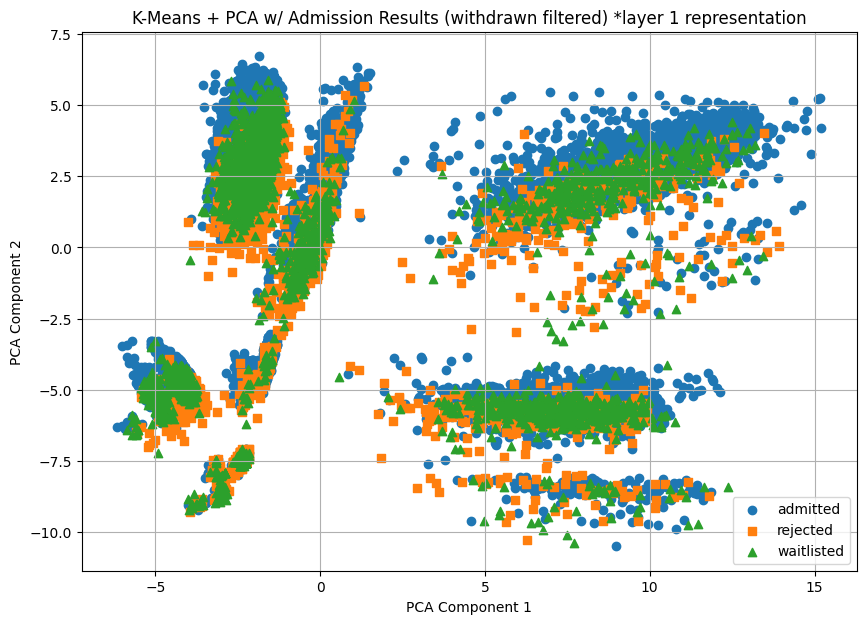

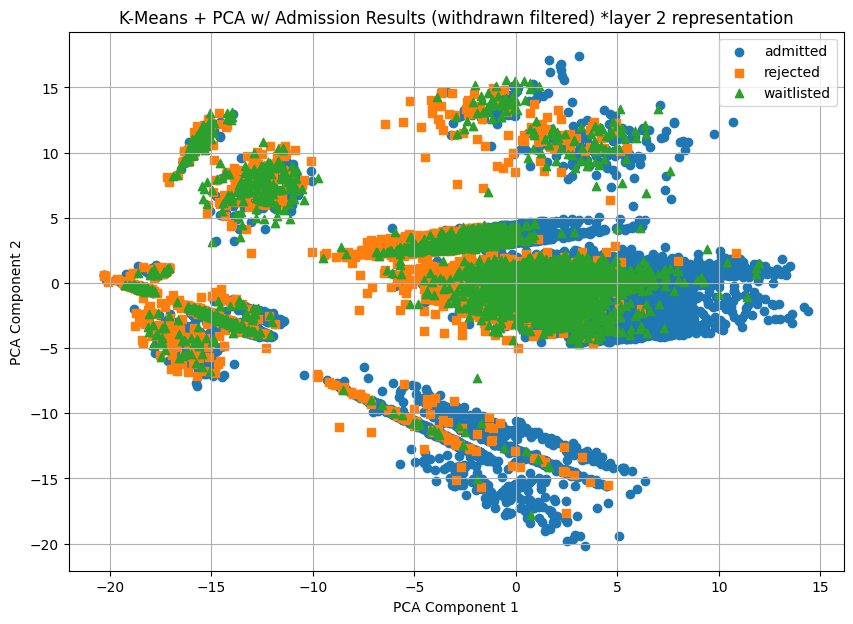

In [55]:

def kmeans_pca_admres(npy_file_path, label_file_path, n_clusters=3, note=''):
	# Step 1: Load data and labels
	scaler = StandardScaler()
	layer1_rep = np.load(npy_file_path)
	labels_one_hot = np.load(label_file_path)

	# Convert one-hot encoded labels to integer labels
	labels = np.argmax(labels_one_hot, axis=1)

	# Standardize the data
	data_standardized = scaler.fit_transform(layer1_rep)

	# Step 2: Perform KMeans Clustering
	kmeans = KMeans(n_clusters=n_clusters, random_state=42)
	kmeans.fit(data_standardized)
	cluster_labels = kmeans.labels_

	# Step 3: PCA for Visualization
	pca = PCA(n_components=2)
	reduced_data = pca.fit_transform(data_standardized)

	# Step 4: Map labels to shapes
	shape_dict = {0: 'o', 1: 's', 2: '^', 3: 'D'}  # Circle, Square, Triangle, Diamond
	labels_ = {
		0: 'admitted',
		1: 'rejected',
		2: 'waitlisted',
		3: 'others/withdrawn'
	}

	plt.figure(figsize=(10, 7))
	for admission_label in np.unique(labels):
		indices = (labels == admission_label)
		plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], 
					marker=shape_dict.get(admission_label, 'o'), 
					label=labels_[admission_label])
	
	plt.title("K-Means + PCA w/ Admission Results (withdrawn filtered) {}".format('*' + note))
	plt.xlabel("PCA Component 1")
	plt.ylabel("PCA Component 2")
	plt.legend()
	plt.grid(True)
	plt.show()

kmeans_pca_admres('data/original/filtered_layer1_rep.npy', 'data/original/filtered_label_admres.npy', n_clusters=3, note='layer 1 representation')
kmeans_pca_admres('data/original/filtered_layer2_rep.npy', 'data/original/filtered_label_admres.npy', n_clusters=3, note='layer 2 representation')


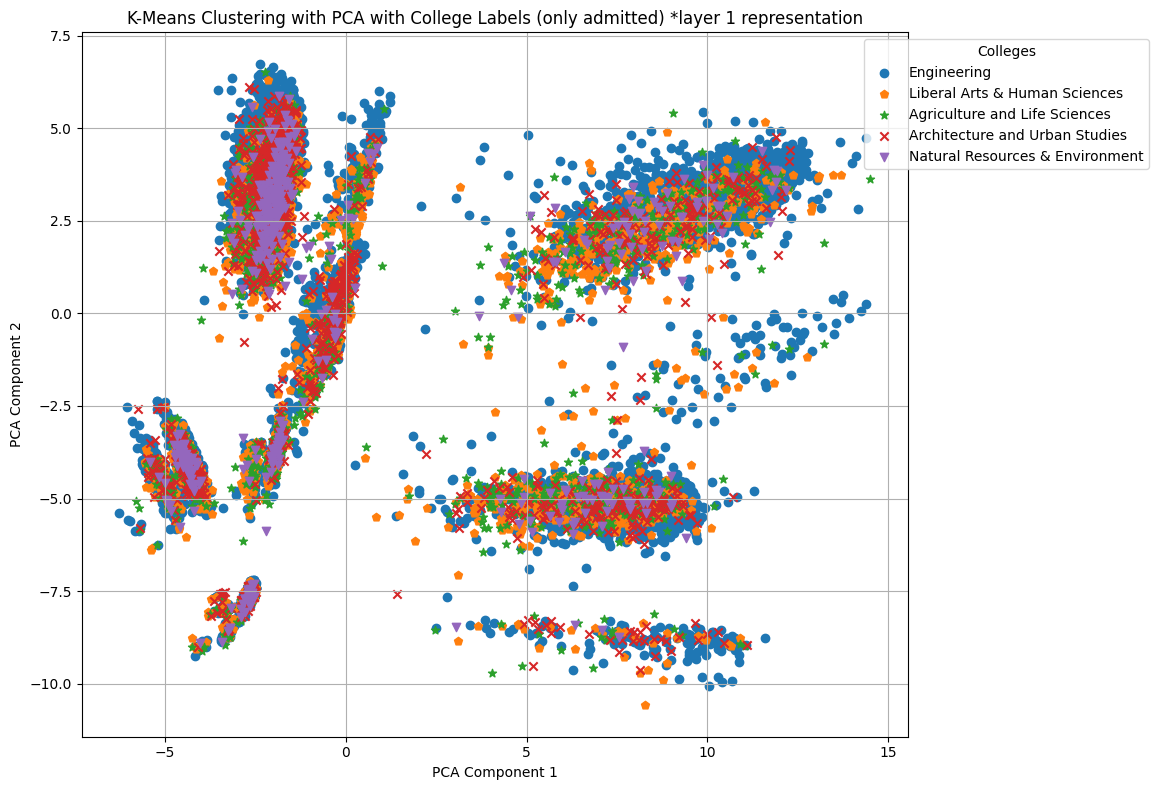

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def kmeans_pca_college(npy_file_path, label_file_path, n_clusters=3, note=''):
    # Step 1: Load data and labels
    scaler = StandardScaler()
    layer1_rep = np.load(npy_file_path)
    labels_one_hot = np.load(label_file_path)

    # Convert one-hot encoded labels to integer labels
    labels = np.argmax(labels_one_hot, axis=1)

    # Define college label mappings
    college_labels = {
        0: 'Engineering',
        1: 'College of Science',
        2: 'Business',
        3: 'Interdisciplinary',
        4: 'Liberal Arts & Human Sciences',
        5: 'Agriculture and Life Sciences',
        6: 'Architecture and Urban Studies',
        7: 'Natural Resources & Environment'
    }

    # Map labels to markers for differentiation
    shape_dict = {0: 'o', 1: 's', 2: '^', 3: 'D', 4: 'p', 5: '*', 6: 'x', 7: 'v'}

    # Standardize the data
    data_standardized = scaler.fit_transform(layer1_rep)

    # Step 2: Perform KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_standardized)
    cluster_labels = kmeans.labels_

    # Step 3: PCA for Visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_standardized)

    # Step 4: Plot with markers and labels for colleges
    plt.figure(figsize=(12, 8))
    for college_label in np.unique(labels):
        indices = (labels == college_label)
        plt.scatter(
            reduced_data[indices, 0], reduced_data[indices, 1],
            marker=shape_dict.get(college_label, 'o'),
            label=college_labels.get(college_label, f"Unknown {college_label}")
        )

    # Add plot details
    plt.title("K-Means Clustering with PCA with College Labels (only admitted) {}".format('*' + note))
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Colleges", loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

kmeans_pca_college('data/original/filtered_layer1_rep_admitted.npy', 'data/original/filtered_label_college_admitted.npy', n_clusters=3, note='layer 1 representation')


### find clusters of applicants who have a higher probability of rejection or waitlisting.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def anomaly_detection(csv_path, n_clusters=3):
    """
    Perform clustering to detect anomalies in applicant data based on academic and test performance.

    Args:
        csv_path (str): Path to the dataset CSV file.
        n_clusters (int): Number of clusters for KMeans.
    """
    # Step 1: Load the dataset
    df = pd.read_csv(csv_path)
    print("Dataset columns:", df.columns)

    # Step 2: Select relevant features for clustering
    features = ['satv_use', 'satm_use', 'satcomp_use', 'act_eng', 
                'act_math', 'act_read', 'act_sci', 'act_comp', 
                'hs_gpa', 'college_gpa']  # Add essay scores if available
    target_col = 'vt_adm_dec'  # Column with admission results

    # Drop rows with missing values in selected features and target column
    data = df[features].dropna()
    labels = df.loc[data.index, target_col]

    # Step 3: Encode admission results numerically
    label_mapping = {'admitted': 0, 'rejected': 1, 'waitlisted': 2, 'others': 3}
    labels_encoded = labels.map(label_mapping)

    # Step 4: Standardize the data for clustering
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Step 5: Apply KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)

    # Step 6: Dimensionality Reduction using PCA for Visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data_scaled)

    # Step 7: Visualization of Clusters and Anomalies
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                          c=labels_encoded, cmap='coolwarm', edgecolor='k', s=50)

    plt.title("Anomaly Detection in Applicant Data via Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Admission Result (0: Admitted, 1: Rejected, 2: Waitlisted, 3: Others)")
    plt.grid(True)
    plt.show()

    # Step 8: Analyze Clusters for Anomalies
    print("\nCluster Analysis:")
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)
        cluster_data = data.iloc[cluster_indices]
        cluster_label_dist = labels_encoded.iloc[cluster_indices].value_counts()
        print(f"\nCluster {cluster}:")
        print("Admission Result Distribution:")
        print(cluster_label_dist)
        print("Average Features in Cluster:")
        print(cluster_data.mean())

# Run the function for anomaly detection
csv_path = 'data/genesis_dataset.csv'  # Update path to the uploaded dataset
anomaly_detection(csv_path, n_clusters=4)
